<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/2.%205Q%20TFIM%20VQNHE%20try%20try%20try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.4/317.4 kB 14.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [2]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [76]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [77]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# VQNHE in Noisy Simulator (Depolarization Channel, Shots = 10000)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [113]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [114]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

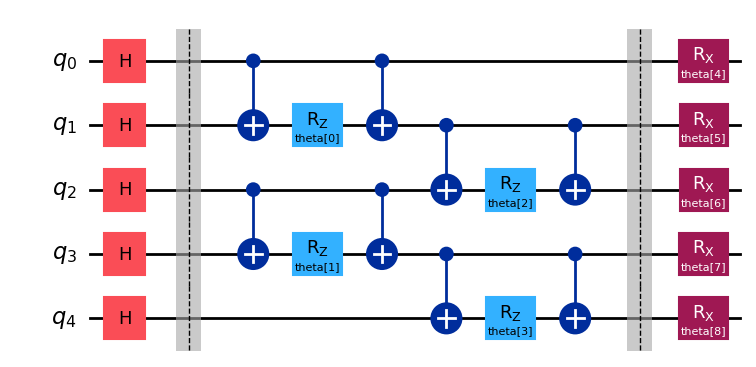

In [115]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

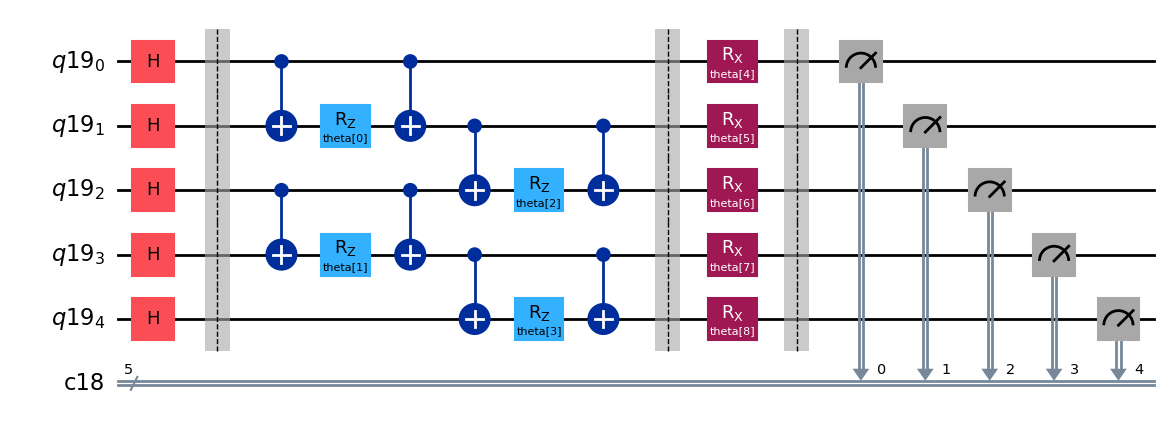

In [116]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

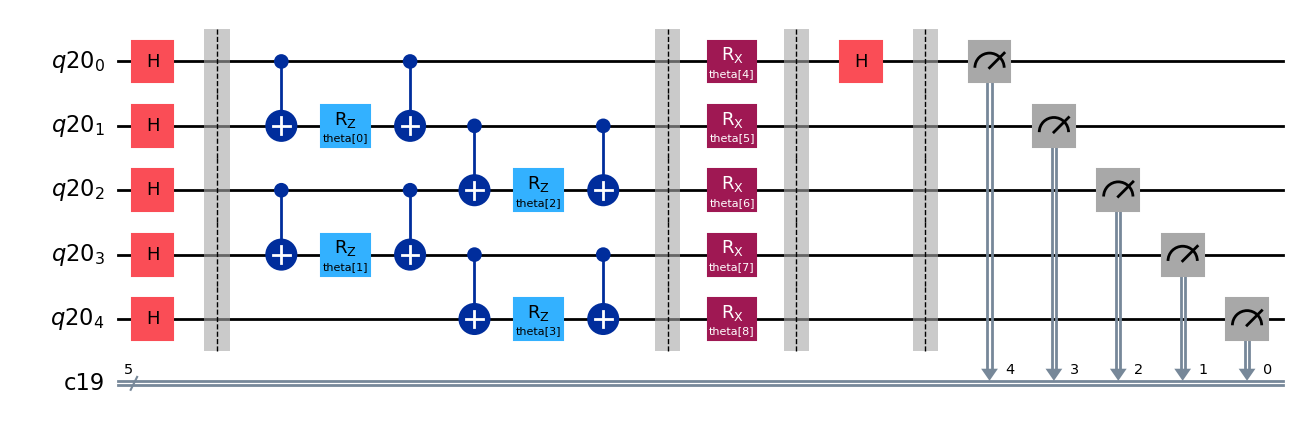

In [117]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

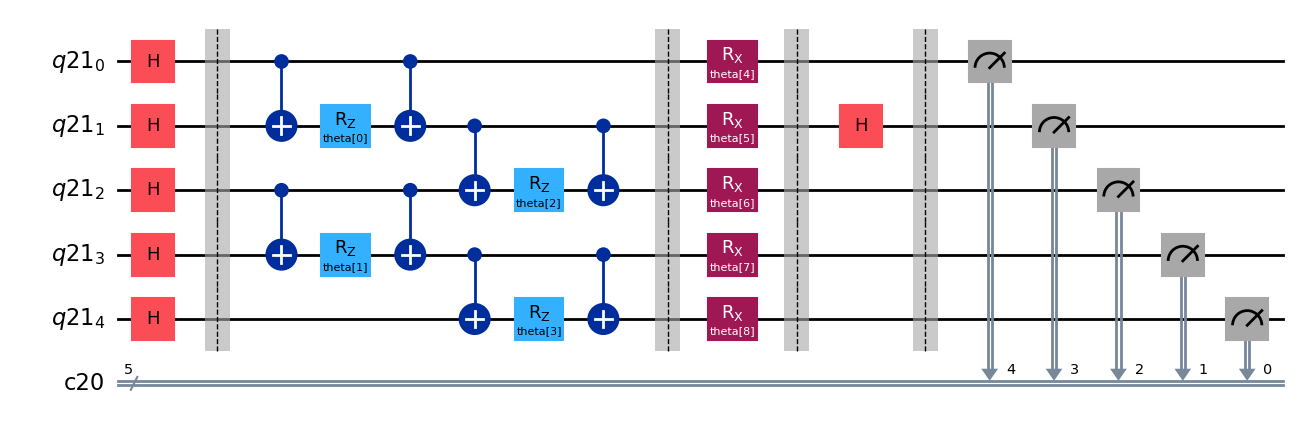

In [118]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

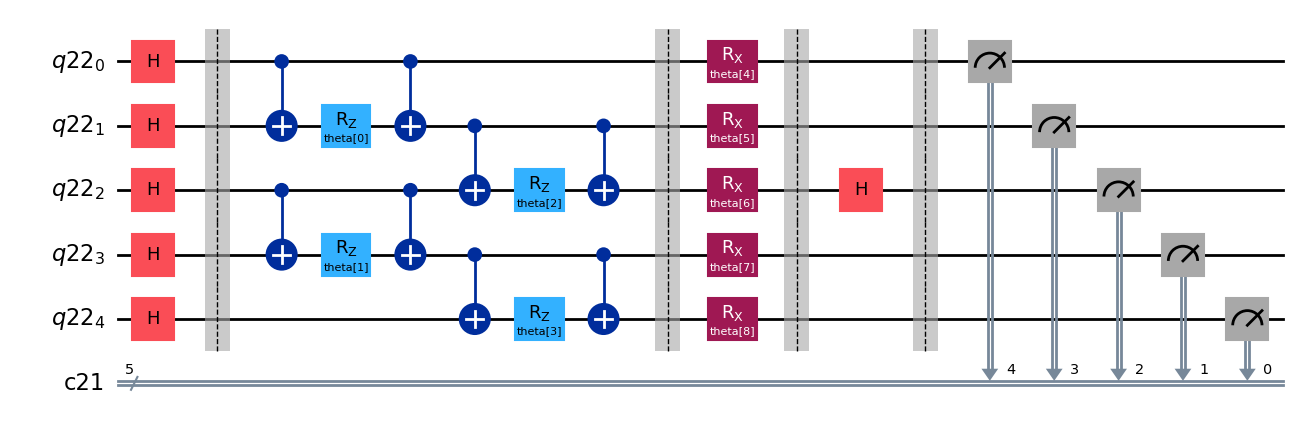

In [119]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

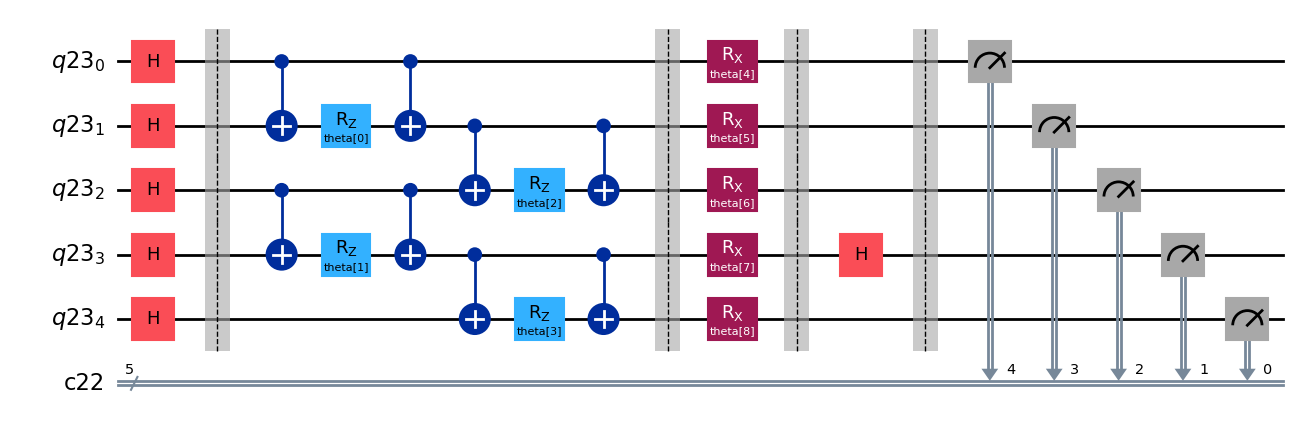

In [120]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

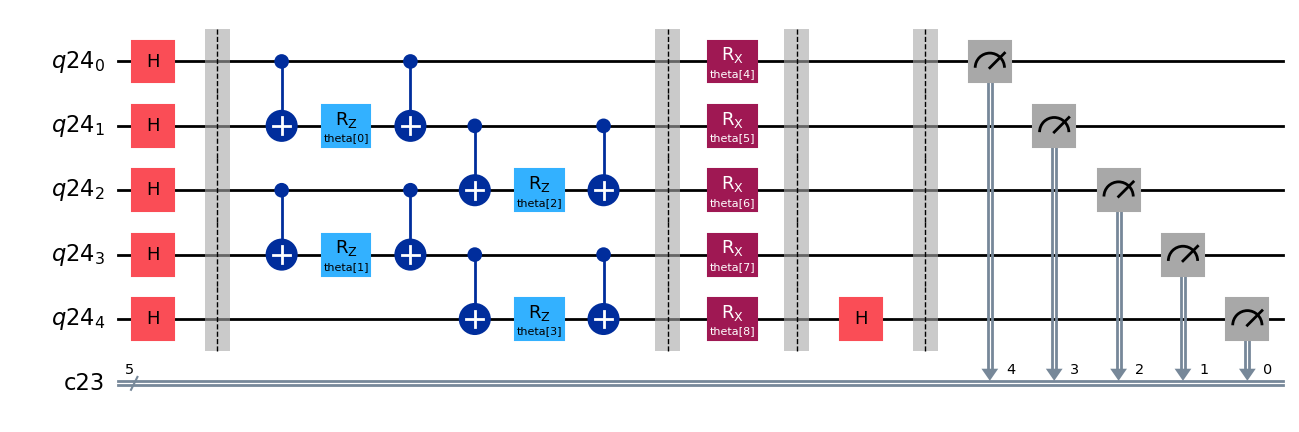

In [121]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

## Cost Function for VQE & VQNHE

In [122]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [123]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [124]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [125]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [126]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [127]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

## VQE & VQNHE

In [128]:
error_list = [0.001*i for i in range(1,51,1)]

In [ ]:
lowest_energy_vqe_list = []

for num in range(1,101,1):

  noise_model = NoiseModel()
  depolar_prob = num*0.001

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100-50, num*100-40, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [131]:
lowest_energy_vqe_list

[-5.8424000000000005,
 -5.7974,
 -5.7886000000000015,
 -5.7562,
 -5.723,
 -5.715,
 -5.698600000000002,
 -5.688400000000001,
 -5.647599999999999,
 -5.6406,
 -5.6258,
 -5.6042000000000005,
 -5.5908,
 -5.565799999999999,
 -5.5402000000000005,
 -5.5234,
 -5.5028,
 -5.4876000000000005,
 -5.4748,
 -5.446199999999999,
 -5.4354000000000005,
 -5.416199999999999,
 -5.3966,
 -5.369199999999998,
 -5.350399999999999,
 -5.334200000000001,
 -5.317799999999998,
 -5.2974,
 -5.2676,
 -5.2608000000000015,
 -5.2406,
 -5.215599999999999,
 -5.199800000000001,
 -5.192799999999999,
 -5.147000000000001,
 -5.1344,
 -5.1274,
 -5.120399999999999,
 -5.1114,
 -5.081600000000001,
 -5.0622,
 -5.0376,
 -5.0378000000000025,
 -4.997,
 -4.986000000000002,
 -4.965199999999999,
 -4.963400000000001,
 -4.937200000000002,
 -4.896,
 -4.885]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(1,51,1):

  noise_model = NoiseModel()
  depolar_prob = num*0.001

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100-50, num*100-40, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 100
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.001, lowest energy vqe : -5.8424000000000005

         Current function value: -5.977859
         Iterations: 100
         Function evaluations: 6032
         Gradient evaluations: 116
         Current function value: -5.901903
         Iterations: 100
         Function evaluations: 6448
         Gradient evaluations: 124
         Current function value: -5.972271
         Iterations: 100
         Function evaluations: 8164
         Gradient evaluations: 157
         Current function value: -5.973893
         Iterations: 100
         Function evaluations: 5824
         Gradient evaluations: 112
         Current function value: -5.973236
         Iterations: 100
         Function evaluations: 7020
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.861441
         Iterations: 34
         Function evaluations: 5154
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965472
         Iterations: 100
         Function evaluations: 7540
         Gradient evaluations: 145
         Current function value: -5.968598
         Iterations: 100
         Function evaluations: 7176
         Gradient evaluations: 138
         Current function value: -5.931347
         Iterations: 100
         Function evaluations: 6656
         Gradient evaluations: 128
         Current function value: -5.934545
         Iterations: 100
         Function evaluations: 6760
         Gradient evaluations: 130
error rate : 0.001, lowest energy vqnhe : -5.97785892138126



error rate : 0.002, lowest energy vqe : -5.7974

         Current function value: -5.947396
         Iterations: 100
         Function evaluations: 5564
         Gradient evaluations: 107
         Current function value: -5.942025
         Iterations: 100
         Function evaluations: 5876
         Gradient evaluations: 113
         Current function value: -5.940030
         It

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.898697
         Iterations: 80
         Function evaluations: 8956
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.940920
         Iterations: 100
         Function evaluations: 6500
         Gradient evaluations: 125
         Current function value: -5.938176
         Iterations: 100
         Function evaluations: 6084
         Gradient evaluations: 117
         Current function value: -5.936399
         Iterations: 100
         Function evaluations: 6188
         Gradient evaluations: 119
         Current function value: -5.940221
         Iterations: 100
         Function evaluations: 5928
         Gradient evaluations: 114
error rate : 0.002, lowest energy vqnhe : -5.947396216036992



error rate : 0.003, lowest energy vqe : -5.7886000000000015

         Current function value: -5.935267
         Iterations: 100
         Function evaluations: 6292
         Gradient evaluations: 121
         Current function value: -5.942674
         Iterations: 100
         Function evaluations: 6188
         Gradient evaluations: 119
         Current function value: -5.91046

In [ ]:
lowest_energy_vqnhe_list

# VQNHE in Noisy Simulator (Depolarization Channel, Shots = 100000)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

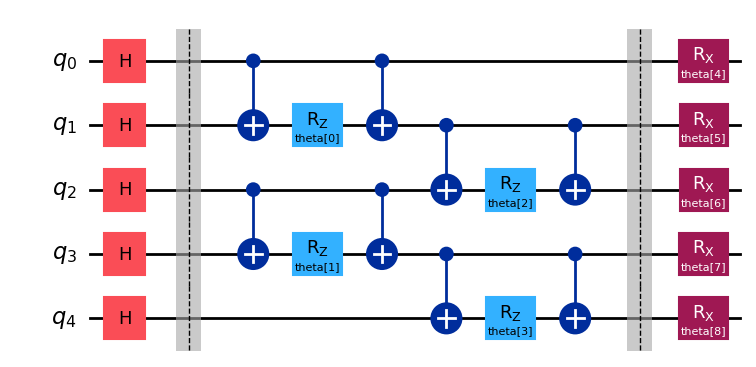

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

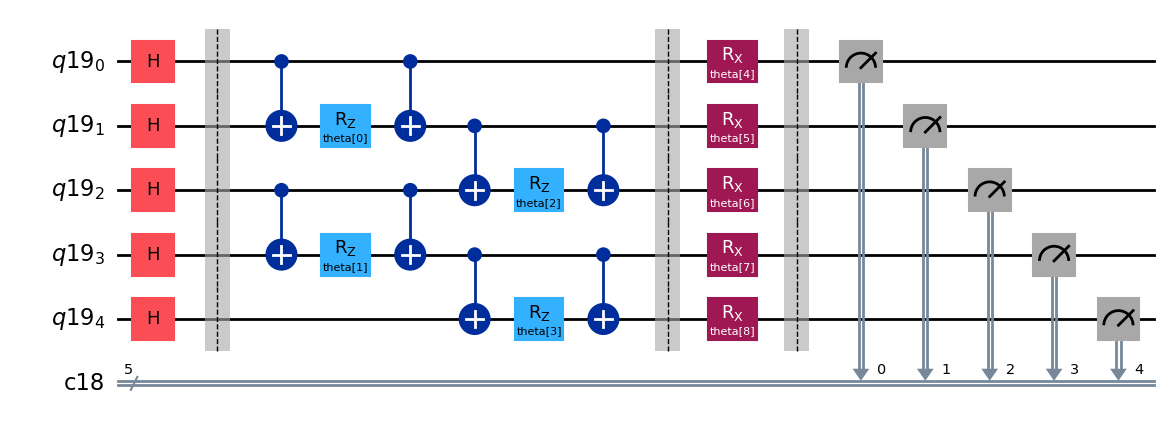

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

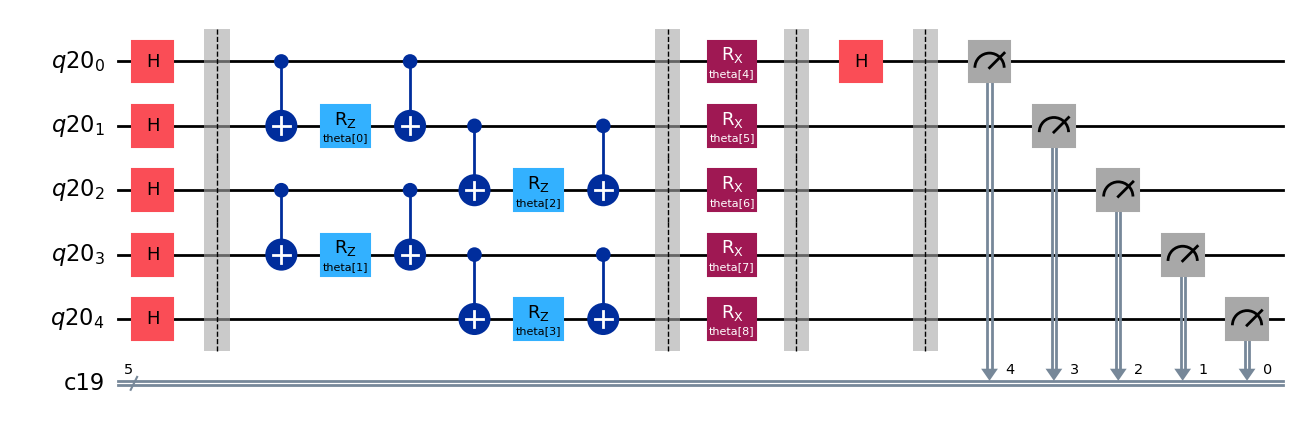

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

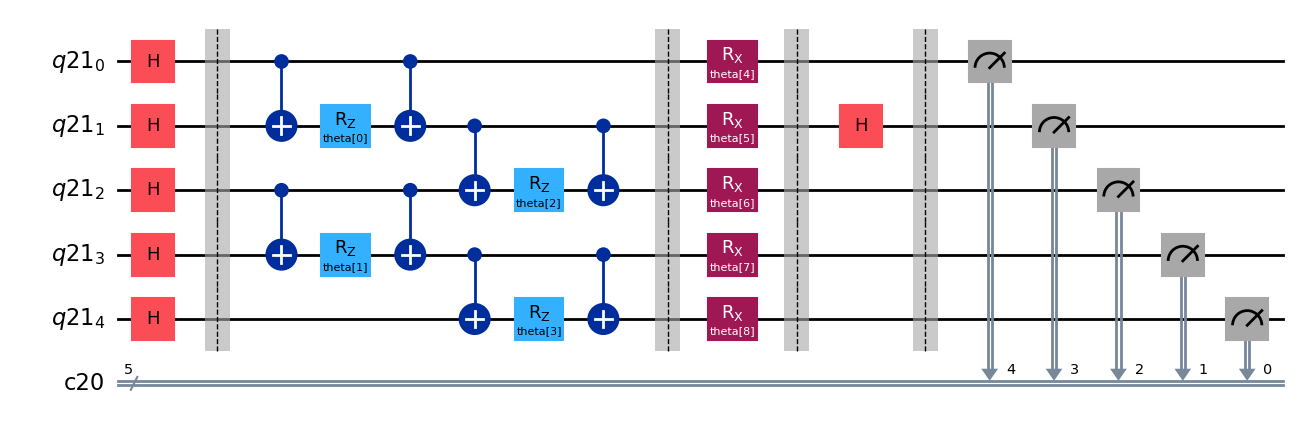

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

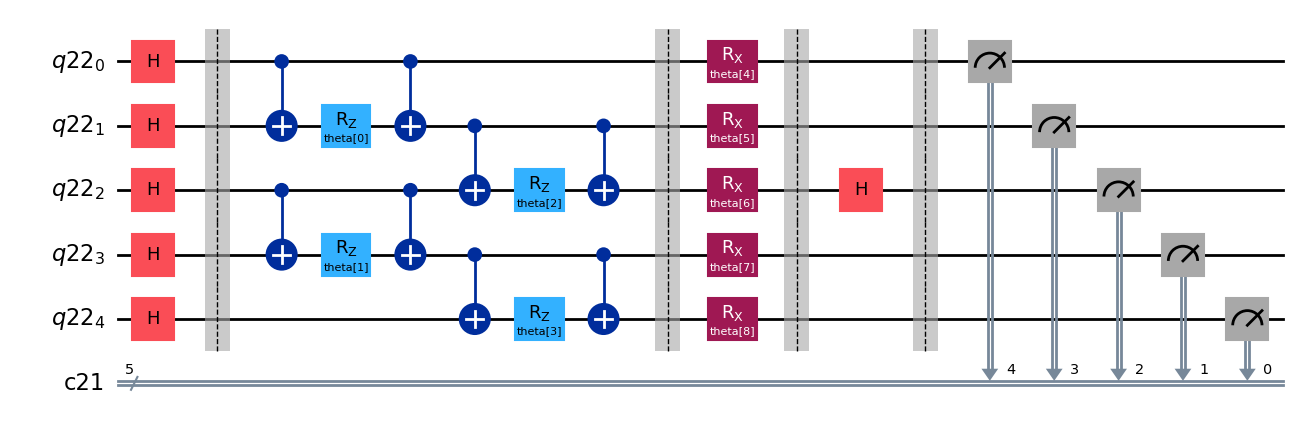

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

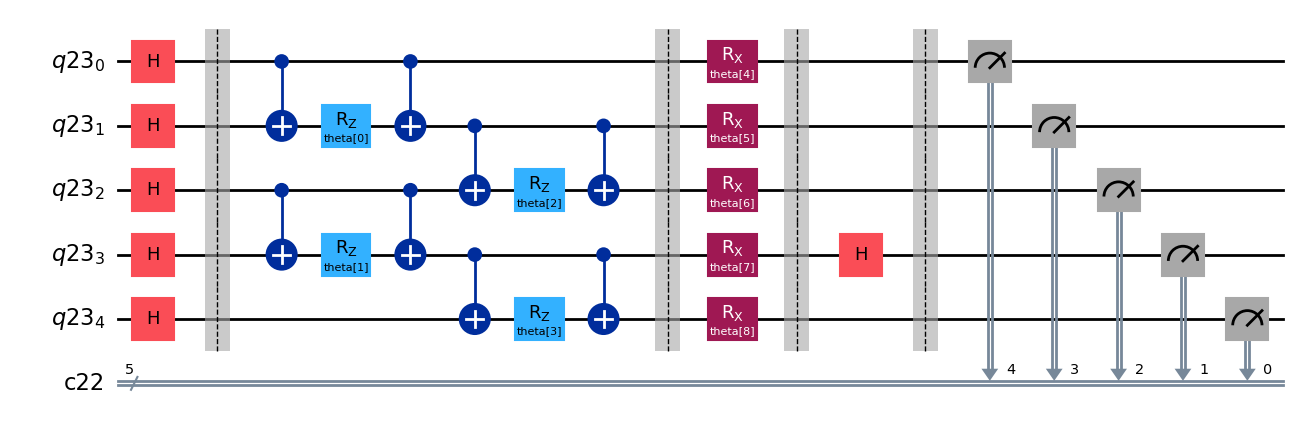

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

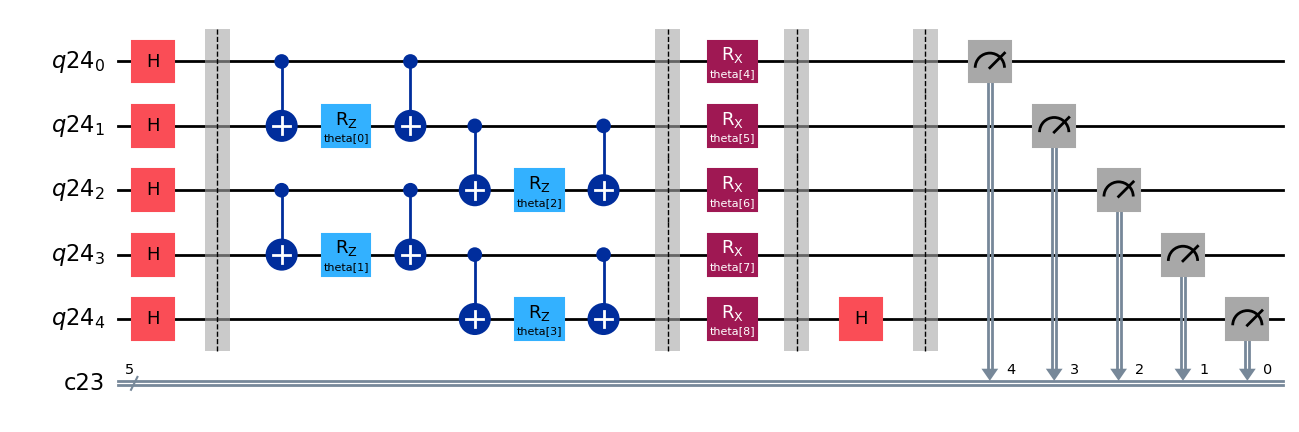

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

## Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

## VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(1,51,1)]

In [ ]:
lowest_energy_vqe_list = []

for num in range(1,51,1):

  noise_model = NoiseModel()
  depolar_prob = num*0.001

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100-50, num*100-40, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(1,51,1):

  noise_model = NoiseModel()
  depolar_prob = num*0.001

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100-50, num*100-40, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 100
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

# VQNHE in Noisy Simulator (Depolarization Channel, Shots = 1000000)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

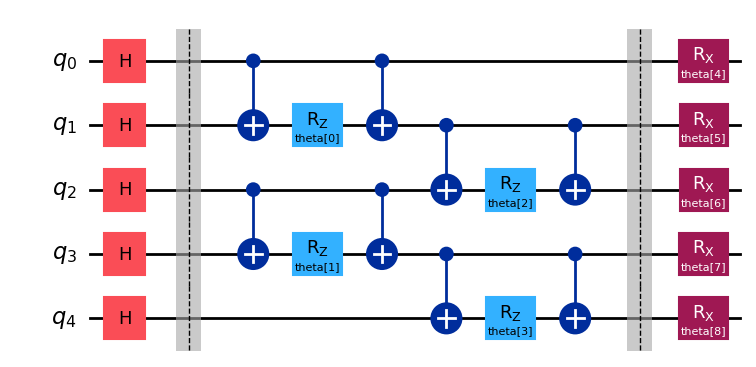

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

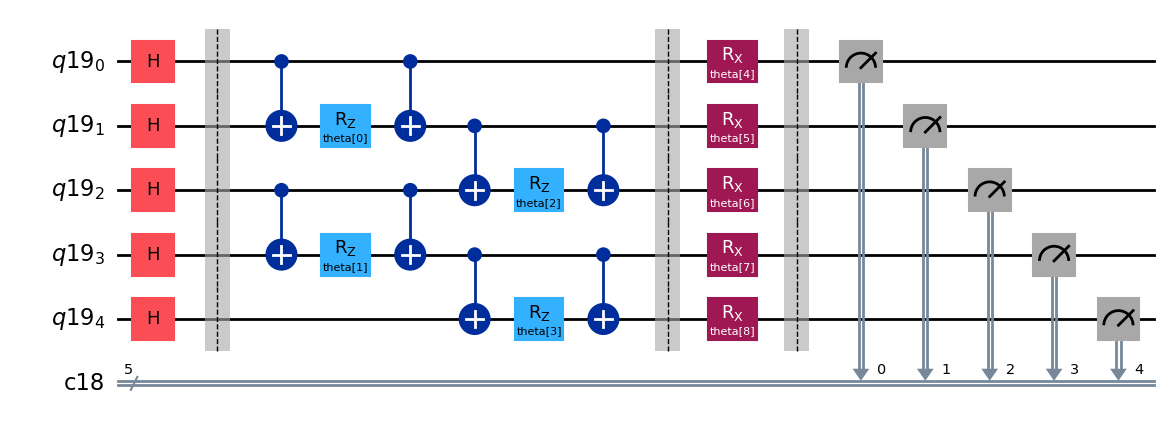

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

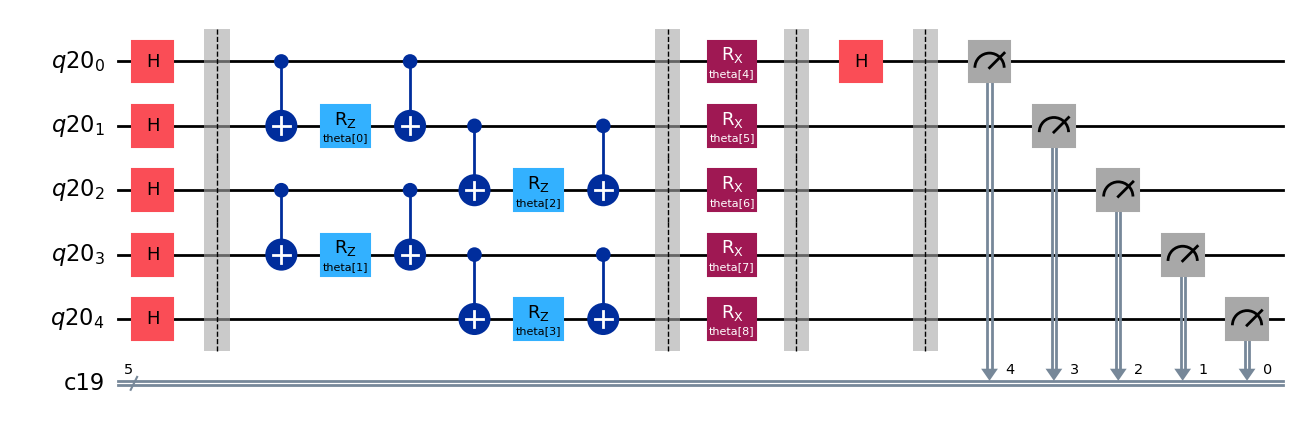

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

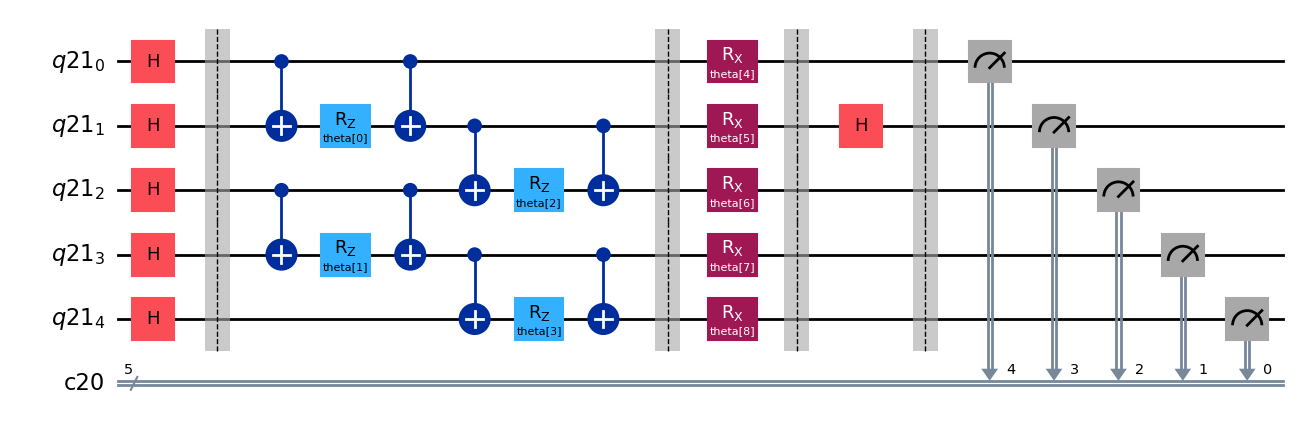

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

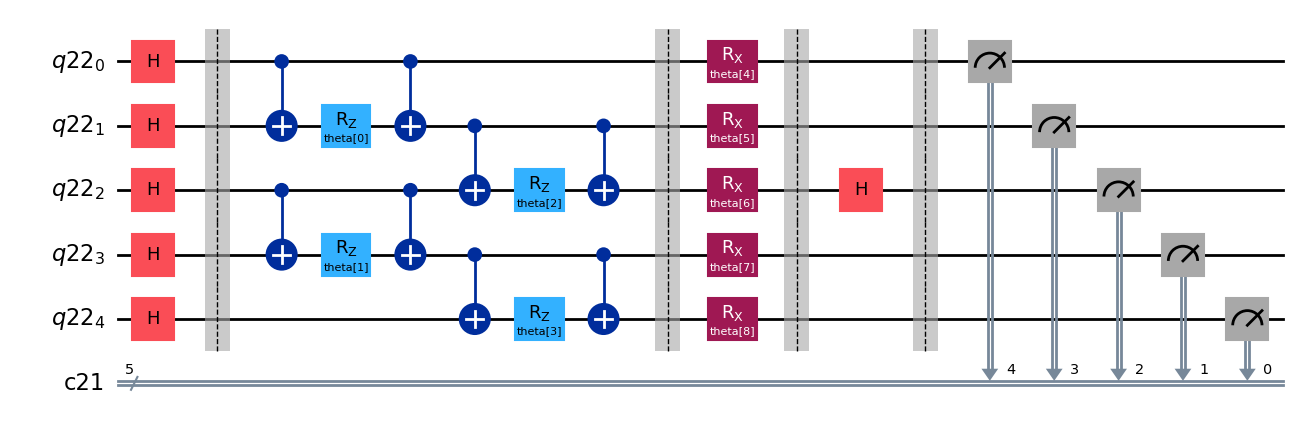

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

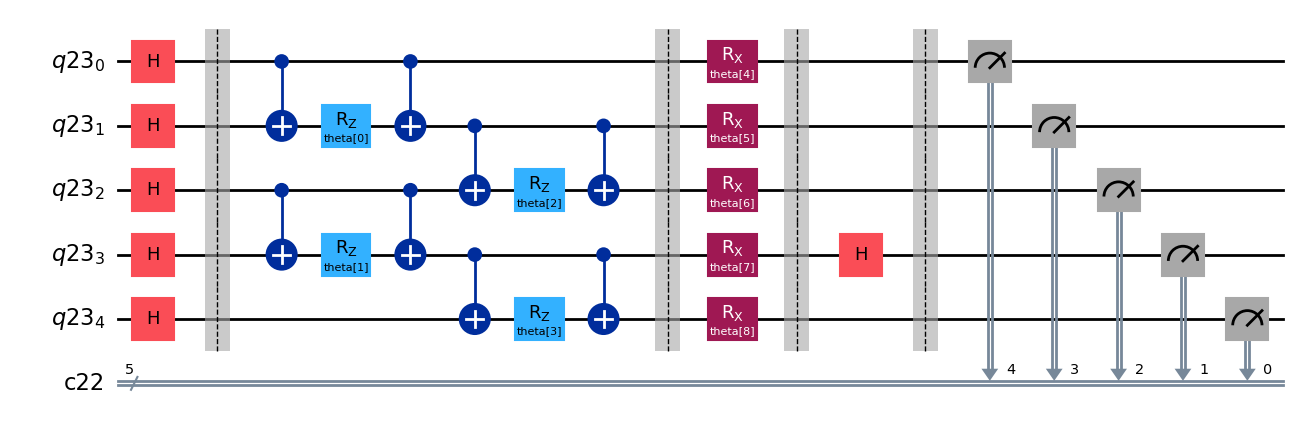

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

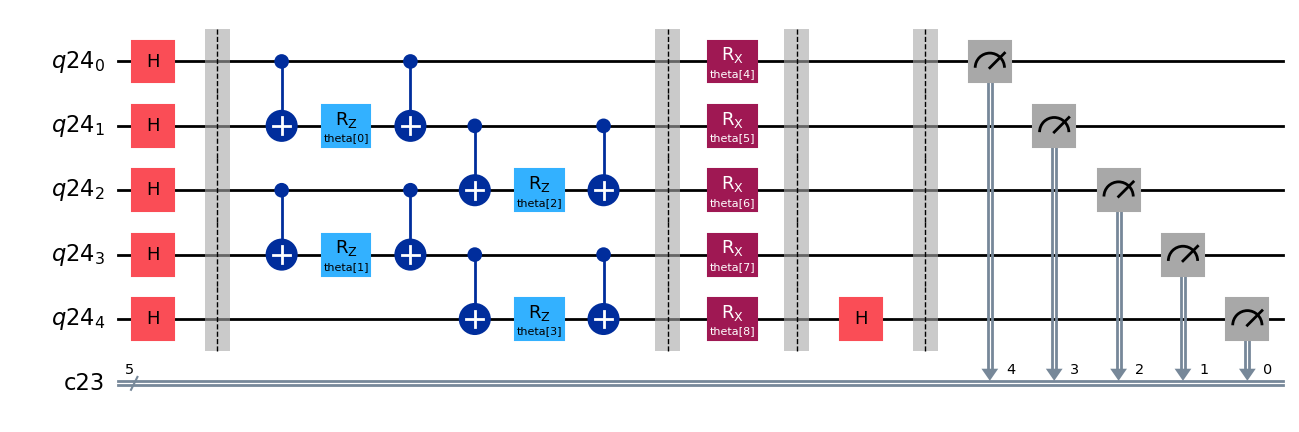

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

## Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  c = parameter[50]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=1000000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=1000000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=1000000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=1000000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=1000000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=1000000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=1000000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

## VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(1,51,1)]

In [ ]:
lowest_energy_vqe_list = []

for num in range(1,51,1):

  noise_model = NoiseModel()
  depolar_prob = num*0.001

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100-50, num*100-40, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(1,51,1):

  noise_model = NoiseModel()
  depolar_prob = num*0.001

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100-50, num*100-40, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=51), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=51), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(51) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 100
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list